In [311]:
#importacion de las bibliotecas de Keras y librerias de Keras

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Num GPUs Available:  1


In [319]:
# importacion del set de entrenamiento
horas_para_LSTM = 540 #cantidad de dias que se toman para predecir el siguiente/horas hacia atras
dataset_train_sinFiltrar = pd.read_csv('Weather_Valencia_Train_2015-2017.csv')
longitudArchivoTrain = len(dataset_train_sinFiltrar)
print("longitudArchivoTrain: ", longitudArchivoTrain)

longitudArchivoTrain:  26366


In [320]:
#filtracion de las columnas que me interesan
dataset_train =dataset_train_sinFiltrar.iloc[:, 2:3]
print(dataset_train)
training_set = dataset_train.values

          temp
0      270.475
1      270.475
2      269.686
3      269.686
4      269.686
...        ...
26361  290.150
26362  290.150
26363  289.150
26364  290.150
26365  289.150

[26366 rows x 1 columns]


In [321]:
# Escalado de caracteristicas

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1)) # normalizacion de los datos
training_set_scaled = sc.fit_transform(training_set)
print("training_set_scaled: ", training_set_scaled) # training es el set de entrenamiento normalizado
print("training_set_scaled.shape: ", training_set_scaled.shape) #


training_set_scaled:  [[0.03885561]
 [0.03885561]
 [0.02021165]
 ...
 [0.48014317]
 [0.50377302]
 [0.48014317]]
training_set_scaled.shape:  (26366, 1)


In [322]:
#Creación de una estructura de datos con 120 (equivale a 5 dias previos) pasos de tiempo y 1 salida
output_a_predecir = 50 #cantidad de horas a predecir

#tratamiento de datos de entrenamiento

X_train = [] #dimension: (cantidad_de_filas_csv, dias a analizar antes, 1)
y_train = [] #dimension: (cantidad_de_filas_csv, valores de los dias futuros, 1)
for i in range(horas_para_LSTM, longitudArchivoTrain-output_a_predecir): #lee a partir  de la fila 120 hasta la cantidad de filas del dataset (26366)
    X_train.append(training_set_scaled[i-horas_para_LSTM:i, 0])  #para mi aca no va 0 
    y_train.append(training_set_scaled[i:i+output_a_predecir , 0]) #para mi aca no va 0


X_train, y_train = np.array(X_train), np.array(y_train) #los transforma en np.array
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

X_train.shape:  (25776, 540)
y_train.shape:  (25776, 50)


In [323]:
#Datos de validacion 

dataset_val_sinFiltrar = pd.read_csv('Weather_Valencia_Test_2018_1S.csv')#importacion del set de validacion
longitudArchivoValidation = len(dataset_val_sinFiltrar)
dataset_validation = dataset_val_sinFiltrar.iloc[:, 2:3]
print(dataset_validation)
validation_set = dataset_validation.values

validation_set_scaled = sc.transform(validation_set)

X_validation = [] #dimension: (cantidad_de_filas_csv, dias a analizar antes, 1)
y_validation = [] #dimension: (cantidad_de_filas_csv, valores de los dias futuros, 1)
for i in range(horas_para_LSTM, longitudArchivoValidation-output_a_predecir): #lee a partir  de la fila 120 hasta la cantidad de filas del dataset (26366)
    X_validation.append(validation_set_scaled[i-horas_para_LSTM:i, 0])  #para mi aca no va 0 
    y_validation.append(validation_set_scaled[i:i+output_a_predecir , 0]) #para mi aca no va 0

X_validation, y_validation = np.array(X_validation), np.array(y_validation) #los transforma en np.array
print("X_validation.shape: ", X_validation.shape)
print("y_validation.shape: ", y_validation.shape)

        temp
0     289.15
1     287.15
2     286.15
3     285.15
4     284.15
...      ...
4383  308.15
4384  309.15
4385  307.15
4386  305.15
4387  305.15

[4388 rows x 1 columns]
X_validation.shape:  (3798, 540)
y_validation.shape:  (3798, 50)


In [324]:
#Remodelación

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) ##aca para meterle mas parametros al tensor
print(X_train.shape)
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1)) ##aca para meterle mas parametros al tensor
print(y_train.shape)
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1)) ##aca para meterle mas parametros al tensor
print(X_validation.shape)
y_validation = np.reshape(y_validation, (y_validation.shape[0], y_validation.shape[1], 1)) ##aca para meterle mas parametros al tensor
print(y_validation.shape)



(25776, 540, 1)
(25776, 50, 1)
(3798, 540, 1)
(3798, 50, 1)


In [325]:
#Importación de las librerías y paquetes Keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [328]:
#Inicializando el RNN

regressor = Sequential()

#Añadiendo la primera capa de LSTM y algo de regularización de la deserción

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Añadiendo la segunda capa de LSTM y algo de regularización de la deserción

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))
#
##Añadiendo la tercera capa de LSTM y algo de regularización de la deserción
#
#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#Añadiendo la cuarta capa de LSTM y algo de regularización de la deserción

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Añadiendo la capa de salida

regressor.add(Dense(units = output_a_predecir))

In [329]:
#Compilación del RNN

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Ajustar el RNN al set de entrenamiento

#Hiperparametros
epocas = 10
batch_size = 32

print(X_train.shape)
print(y_train.shape)

#(26196, 120, 1)
#(26196, 50, 1)

resultado=regressor.fit(X_train, y_train, epochs = epocas,validation_data=(X_validation,y_validation),batch_size = batch_size)

(25776, 540, 1)
(25776, 50, 1)
Epoch 1/10


2023-11-29 23:58:12.592093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55676160 exceeds 10% of free system memory.
2023-11-29 23:58:12.667576: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55676160 exceeds 10% of free system memory.


806/806 [==============================] - 35s 40ms/step - loss: 0.0197 - val_loss: 0.0048
Epoch 2/10
806/806 [==============================] - 32s 39ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 3/10
806/806 [==============================] - 33s 41ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 4/10
629/806 [======================>.......] - ETA: 6s - loss: 0.0058

In [ ]:
#TRATAMIENTO DE TEST

#Obtención del clima

dataset_test = pd.read_csv('Weather_Valencia_Test_2018_2S.csv')
longitudArchivoTest = len(dataset_test)
real_weather_temp = dataset_test.iloc[:, 2:3].values
ytest=[]
#Obtención del precio de las acciones previsto para 2017

dataset_total_previo = pd.concat((dataset_train['temp'], dataset_validation['temp']), axis = 0) #concatena los datos de entrenamiento y los de test
dataset_total = pd.concat((dataset_total_previo, dataset_test['temp']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - horas_para_LSTM:].values #toma los ultimos 120 HORAS del 2016
inputs = inputs.reshape(-1,1) #transforma los datos en un array de 1 columna
inputs = sc.transform(inputs) #normaliza los datos
print(inputs.shape)


X_test = [] #crea un array vacio

for i in range(horas_para_LSTM, longitudArchivoTest): #toma los ultimos 120 dias del 2016 
    X_test.append(inputs[i-horas_para_LSTM:i, 0])
    ytest.append( inputs[i:i+output_a_predecir , 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

ytest = np.array(ytest) 
ytest = np.reshape(ytest, (ytest.shape[0], ytest.shape[1], 1)) ##aca para meterle mas parametros al tensor
ytest = ytest.squeeze()

ytest = sc.inverse_transform(ytest)

print(ytest)
print(ytest.shape)

print(X_test.shape)

predicted_weather_temp = regressor.predict(X_test) #x_TEST DEBERIA SER SHAPE (FILAS DE ARCHIVO TEST, DIAS A ANALIZAR ANTERIORES)
print(predicted_weather_temp.shape) #Deberia tener 8780 filas y tantas columnas como valores a predecir
predicted_weather_temp = sc.inverse_transform(predicted_weather_temp)


(4511, 1)
[[304.15 303.15 302.15 ... 300.15 299.15 298.15]
 [303.15 302.15 302.15 ... 299.15 298.15 298.15]
 [302.15 302.15 300.15 ... 298.15 298.15 298.15]
 ...
 [283.14 283.14 283.64 ... 279.14 278.64 277.14]
 [283.14 283.64 283.14 ... 278.64 277.14 276.64]
 [283.64 283.14 282.14 ... 277.14 276.64 276.64]]
(4271, 100)
(4271, 120, 1)
134/134 [==============================] - 1s 4ms/step
(4271, 100)


(4391, 1)
(4271, 100)


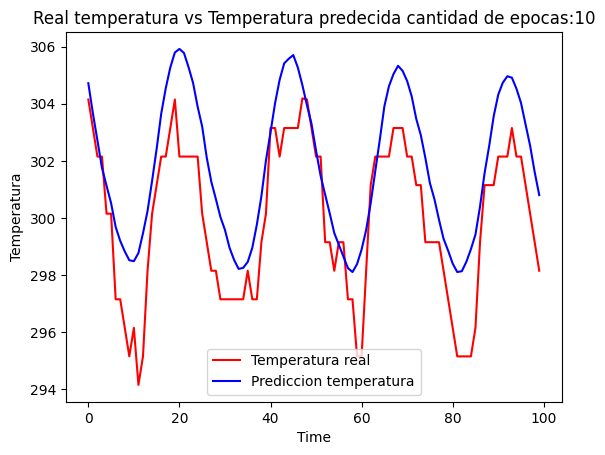

In [ ]:
#PREDICION A PARTIR DE LAS PREDICCIONES ARTIFICIALES

#xgrafico = np.arange(0, output_a_predecir, 1)
#print(xgrafico.shape)

print(real_weather_temp.shape)
valoresReales = real_weather_temp[:output_a_predecir]
#valoresReales = real_weather_temp[110:160]
print(predicted_weather_temp.shape)

datos_a_graficar = predicted_weather_temp[:1]


datos_a_graficar = datos_a_graficar.reshape(-1,1)


#plt.figure(figsize=(20,100))
plt.plot(valoresReales, color = 'red', label = 'Temperatura real')
plt.plot(datos_a_graficar, color = 'blue', label = 'Prediccion temperatura')
#plt.scatter(xgrafico,real_weather_temp, color = 'red', label = 'Real weather temperatura')
#plt.scatter(xgrafico,predicted_weather_temp, color = 'blue', label = 'Predicted weather temperatura')
plt.title('Real temperatura vs Temperatura predecida cantidad de epocas:'+str(epocas) ) 
plt.xlabel('Time')
plt.ylabel('Temperatura')
plt.legend()
plt.show()


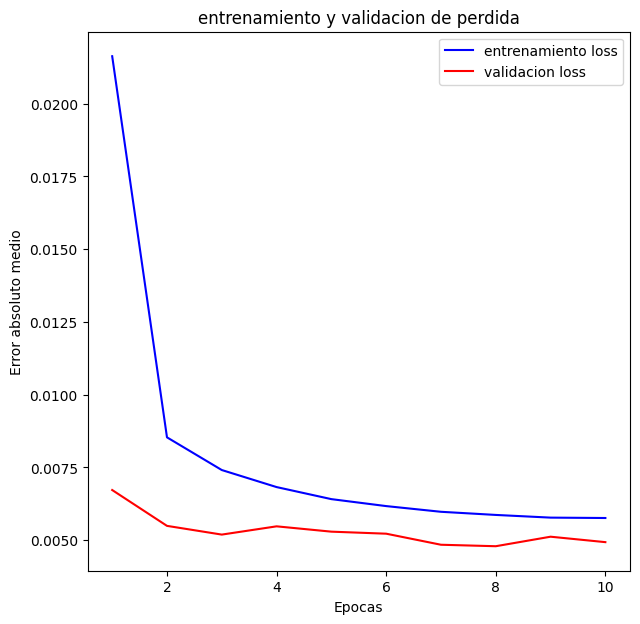

In [ ]:
loss = resultado.history['loss']
val_loss = resultado.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(7,7))
plt.plot(epochs, loss, 'b', label='entrenamiento loss')
plt.plot(epochs, val_loss, 'r', label='validacion loss')
plt.title('entrenamiento y validacion de perdida')
plt.xlabel('Epocas')
plt.ylabel('Error absoluto medio')
plt.legend()
plt.show()


y_test:  [[304.15 303.15 302.15 ... 300.15 299.15 298.15]
 [303.15 302.15 302.15 ... 299.15 298.15 298.15]
 [302.15 302.15 300.15 ... 298.15 298.15 298.15]
 ...
 [283.14 283.14 283.64 ... 279.14 278.64 277.14]
 [283.14 283.64 283.14 ... 278.64 277.14 276.64]
 [283.64 283.14 282.14 ... 277.14 276.64 276.64]]
y_test.shape:  (4271, 100)
Error cuadratico medio:  [1.5058871  1.68001083 1.83471436 1.93417688 2.05894    2.15482285
 2.16907273 2.22448755 2.25317232 2.2522846  2.26561849 2.27718166
 2.31329889 2.32671292 2.33287816 2.34420321 2.37080698 2.3418787
 2.32733459 2.32654781 2.31195172 2.30878039 2.28291241 2.32041439
 2.34917792 2.41599692 2.42196168 2.45454866 2.50963911 2.54238143
 2.59135195 2.59657779 2.60394412 2.60910875 2.62903897 2.63390271
 2.6161168  2.63339331 2.62080951 2.66055459 2.65217288 2.64319657
 2.64130054 2.64865851 2.64589811 2.70619033 2.69284009 2.69567986
 2.74160771 2.79254404 2.78955822 2.79307709 2.7999997  2.81612814
 2.8036134  2.85462995 2.86709772 2.8

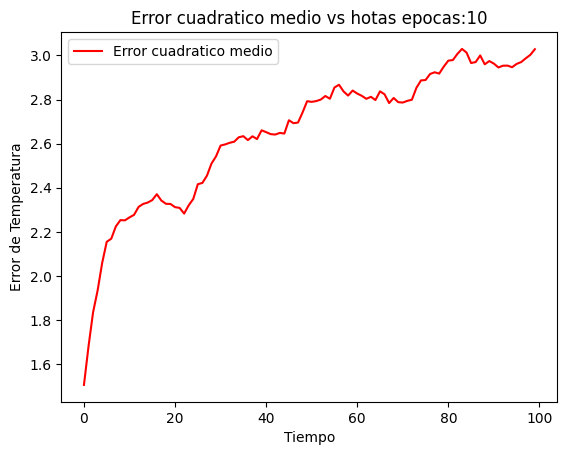

In [ ]:
# EL BUENO
xgrafico = np.arange(0, 8779, 1)
#print(xgrafico.shape)
#print(ytest.shape)

# Calculamos el error minimo cuadrado


print("y_test: ", ytest)
print("y_test.shape: ", ytest.shape)

diferencia = np.square(ytest.squeeze()-predicted_weather_temp) 
promedio = np.mean(diferencia, axis=0) 
ecm = np.sqrt(promedio) 
ecmgeneral=np.mean(ecm)
print("Error cuadratico medio: ",ecm)


plt.plot(ecm, color = 'red', label = 'Error cuadratico medio')
#plt.plot(predicted_weather_temp, color = 'blue', label = 'Prediccion temperatura')
#plt.plot(ytest, color = 'red', label = 'Temperatura real',linewidth=0.5)
#plt.figure(figsize=(20,100))
#plt.scatter(xgrafico,real_weather_temp, color = 'red', label = 'Real weather temperatura')
#plt.scatter(xgrafico,predicted_weather_temp, color = 'blue', label = 'Predicted weather temperatura')
plt.title('Error cuadratico medio vs horas. Cant Epocas:'+str(epocas) ) 
plt.xlabel('Tiempo')
plt.ylabel('Error de Temperatura')
plt.legend()
#plt.legend()
plt.show()

